# Plots of ICESat-2/ATLAS transects at field sites

with field observations at ground level (TODO) and from UAV 

https://docs.google.com/spreadsheets/d/1jqP0K0LZmswK4ZZNU6BxKYgjaBZM0HRkUrWS1QFLvIE/edit?gid=0#gid=0  

could be used for manuscript:
https://docs.google.com/document/d/1uj9-xlLTJK1xeGvzIEHvNNnquXYMUNsBDB30a3HhlOc/edit?usp=sharing

| Author | Affiliation | Date |
| --- | --- | --- |
| Paul Montesano, PhD | Innovation Lab ; NASA Goddard Space Flight Center | Sept. 2024 |

In [2]:
import os
import pandas as pd
import geopandas as gpd
import glob
import rasterio
import pyproj
import matplotlib.pyplot as plt
import warnings
import folium
from folium import plugins
import fiona
import numpy as np
from basemaplib import *

/explore/nobackup/people/pmontesa/.nccstmp/ipykernel_162910/4279244517.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/../../.././libtiff.so.6: version `LIBTIFF_4.6.1' not found (required by /app/jupyter/ilab/jupyter-lab/prod/lib

In [3]:
import plotnine
from plotnine import *

### CHM model training chips

In [4]:
# chips_df_ifsar_chm_gdf = gpd.read_file('/explore/nobackup/people/mmacande/srlite/chm_model/20231014_chm/chips_df_ifsar_chm_nodtm_v20231014.gpkg')
# chips_df_lidar_chm_gdf = gpd.read_file('/explore/nobackup/people/mmacande/srlite/chm_model/20231014_chm/chips_df_lidar_nodtm_v20231014.gpkg')

In [5]:
class_name_list =  list(reversed(['Noise','Ground','Canopy','Top of canopy'][1:]))
class_color_list = list(reversed(['lightgrey','brown','lightgreen','darkgreen'][1:]))

In [6]:
EXPEDITION_ID = 'sewardpen2024'
OUTDIR = f'/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/field/{EXPEDITION_ID}'
OUTDIR_PLOTS = '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/plots'

### UAV data footprints

In [7]:
footprint_uav_gdf = gpd.read_file(f'{OUTDIR}/footprints_uav_sewardpen2024_RGB_COG.gpkg')

## Read tables: Raster CHM extractions at field points

In [8]:
# Read seward reference data frame
all_ref_m = pd.read_csv(os.path.join(OUTDIR, 'sewardpen2024_all_rs_validation.csv'))
all_ref_gdf_extract = gpd.read_file(os.path.join(OUTDIR, 'sewardpen2024_all_rs_validation_unmelted.gpkg'))

/explore/nobackup/people/pmontesa/.nccstmp/ipykernel_162910/2903023123.py:2: DtypeWarning: Columns (13,17) have mixed types. Specify dtype option on import or set low_memory=False.


## Exploratory plotting

In [9]:
from scipy import stats
import sklearn.metrics as metrics

In [10]:
def validation_smry_stats(g, ref_var, src_var):
    
    n = len(g)
    # Calculate best fit line
    slope, intercept, r_value, p_value, std_err = stats.linregress(g[ref_var], g[src_var])

    # Regression metrics
    explained_variance =  metrics.explained_variance_score(g[ref_var], g[src_var])
    mean_absolute_error = metrics.mean_absolute_error(g[ref_var], g[src_var]) 
    mse                 = metrics.mean_squared_error(g[ref_var], g[src_var]) 
    rmse                = np.sqrt(mse) 
    #mean_squared_log_error=metrics.mean_squared_log_error(g[ref_var], g[src_var])
    median_absolute_error = metrics.median_absolute_error(g[ref_var], g[src_var])
    r2score             = metrics.r2_score(g[ref_var], g[src_var])

    if False:
        print('explained_variance: ', round(explained_variance,4))    
        #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
        print('r2: ', round(r2score,4))
        print('MAE: ', round(mean_absolute_error,4))
        print('MSE: ', round(mse,4))
        print('RMSE: ', round(rmse,4))

    return pd.Series(dict(n=n, slope=slope, intercept=intercept, r_value=r_value, p_value=p_value, std_err=std_err, ref_var=ref_var, r2score = r2score, expvarscore=explained_variance, mae=mean_absolute_error, mse=mse, rmse=rmse, medae=median_absolute_error))   

In [11]:
all_ref_m['source_extent'].unique()

array(['Local', 'Circumpolar', 'Global', 'Regional'], dtype=object)

In [12]:
all_ref_m['source_cat'].unique()

array(['Observation', 'Machine Learning', 'Deep Learning'], dtype=object)

#### Function for some facet plots

In [13]:
def do_facet_plots(LIST_ID_VARS, tmp_df, STR_FACET_VARS_COLS, STR_FACET_VARS_ROWS='.', MAX_VAL=5):
    # Run the validation stats
    smry = round(tmp_df.groupby(LIST_ID_VARS).apply(validation_smry_stats, 'height_ref', 'value').reset_index() , 2).dropna()
    print(smry.shape)
    smry['r2_value'] = round(smry['r_value'] * smry['r_value'], 2)
    smry['r2_value_str'] = f"$r^2$: " + smry['r2_value'].astype(str)
    smry['rmse_str'] = f"rmse [m]: " + smry['rmse'].astype(str)
    smry['mae_str'] = f"mae [m]: " + smry['mae'].astype(str)
    smry['bias_str'] = f"bias [m]: " + smry['intercept'].astype(str)

    max_val = MAX_VAL
    lab_sz = 10
    p = (
        ggplot(tmp_df
               , aes(y='value', x='height_ref'))
        + labs(x = 'Vegetation height reference (m)', y= 'Vegetation height prediction (m)', title='Fine-tuned deep learning predictions of VHR CHMs\ntransitional vegetation height validation (Seward Peninsula, Alaska)')
        + geom_bin2d(binwidth=0.25)
            #+ geom_point(aes(group='type'), size=0.75, alpha=0.01)
        + geom_abline()
            + geom_label(data=smry, mapping=aes(x=0, y=max_val, label='r2_value_str'), ha='left', va='top', size=lab_sz)
            + geom_label(data=smry, mapping=aes(x=0, y=max_val-0.5, label='rmse_str'), ha='left', va='top', size=lab_sz)
            + geom_label(data=smry, mapping=aes(x=0, y=max_val-1, label='mae_str'), ha='left', va='top', size=lab_sz)
            + geom_label(data=smry, mapping=aes(x=0, y=max_val-1.5, label='bias_str'), ha='left', va='top', size=lab_sz)
            + coord_cartesian(ylim=(0,max_val), xlim=(-2,max_val))
            + scale_fill_cmap(cmap_name='plasma', trans='log10', name='# obs.')

            #+ facet_grid(f'. ~ {FACET_VAR}')
            #+ facet_grid(f'{FACET_VAR_LIST[0]} ~ {FACET_VAR_LIST[1]}')
        # + scale_fill_cmap(name = "count", trans = "log", cmap_name = 'plasma',
        #                     breaks = [1, 10,25,50,150,500], labels = [1, 10,25,50,150,500]
        #               )
        #+ facet_grid('. ~ source_cat + source_extent + source_type')
        + facet_grid(STR_FACET_VARS_ROWS +' ~ ' + STR_FACET_VARS_COLS)
        + theme_bw() 
        #+ coord_equal(xlim = (0,100), ylim = (0,100))
        + theme(strip_text_x = element_text(size=12), axis_text = element_text(size=14), axis_title = element_text(size=14))
        + guides(color = guide_legend(override_aes = {'size' : 4, 'alpha': 1}))
    )#.draw(show=False, return_ggplot=True)
    #return fig, p
    return p

In [14]:
all_ref_m['source_extent'] = pd.Categorical(all_ref_m['source_extent'], categories=[ 'Global','Circumpolar','Regional', 'Local'])
all_ref_m['source_cat']    = pd.Categorical(all_ref_m['source_cat'],    categories=[ 'Observation','Machine Learning','Deep Learning'])
df = all_ref_m[
                        (all_ref_m.value != -9999) & # universal nodata value
                        (all_ref_m.value != 255) &   # accidental 255 nodata value in there instead of -9999 for one of the datasets..
                        #(all_ref_m.height_ref < 100 ) &  
                        (
                            (all_ref_m.type_ref == 'field 2m' ) | 
                            (all_ref_m.type_ref == 'field 0.3m' )\
                            & ~((all_ref_m.source_type == 'VHR CHM v1.0 (UNet)') & (all_ref_m.source_res =='10m')) # this gets rid of the NASA vhr 10m resampled version that was just a test
                            # this gets rid of the nasa deep learning 10m resampled version
                        # | ((all_ref_m.type_ref == 'ATL03' ) & (all_ref_m.class_name != 'Ground')) 
                        ) # Use only field obs as reference data (no ATL03)
                    ]


In [15]:
df.shape

(56350, 19)

In [16]:
df.source_type.unique()

array(['CHM (ref.; UAV)', 'NASA|UMd HLS', 'NASA|UMd S1+HLS',
       'Pub: Tolan et al. 2024', 'Pub: Lang et al. 2023',
       'Pub: Potapov et al. 2021', 'VHR CHM v1.0 (UNet)',
       'VHR CHM v2.1 (ViT DINOv2)', 'VHR CHM v2.2.1 (ViT DINOv2-RS)',
       'VHR CHM v2.2.2 (ViT DINOv2-RS)', 'VHR CHM v2.2.3 (ViT DINOv2-RS)',
       'VHR CHM v2.2.4 (ViT DINOv2-RS)', 'VHR CHM v1.5.1 (UNet)',
       'VHR CHM v1.5.2 (UNet)', 'VHR CHM v3.3.2.1 (DINOv3)', 'UAV',
       'CHM (training; IFSAR)'], dtype=object)

In [17]:
df.rename(columns=lambda x: x.split('chm_')[0], inplace=True)

/explore/nobackup/people/pmontesa/.nccstmp/ipykernel_162910/2114012575.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [18]:
# Split the strings in 'col1' by the delimiter ' ' (space) and rename the columns
df[['source_simple', 'source_extra1']] = df['source'].str.split('chm_', n=1, expand=True)
df[['source_simple', 'source_extra2']] = df['source_simple'].str.split('cnn', n=1, expand=True)
df[['source_extra3', 'source_simple']] = df['source_simple'].str.split('ht_', n=1, expand=True)


# Drop the original column if needed
#df.drop('col1', axis=1, inplace=True)

/explore/nobackup/people/pmontesa/.nccstmp/ipykernel_162910/3458552966.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/explore/nobackup/people/pmontesa/.nccstmp/ipykernel_162910/3458552966.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/explore/nobackup/people/pmontesa/.nccstmp/ipykernel_162910/3458552966.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

In [19]:
df.source_simple.unique()

array(['uavchm030', 'uavchm200', 'boreal_H30_2020', 'boreal_S1H30_2020',
       'tolan', 'lang', 'potapov', 'nasa_', '20110727_103001000D914900',
       '20120721_103001001AB23900', '20160817_103001005B484100',
       '20190820_10300100954DE000', '20190820_10300100968FB300',
       '20190820_1030010099BF2F00', '20200722_10300100AB1FD100',
       '20170719_104001002F7A2E00', '20190822_104001005054F700',
       '20200704_104001005EADB900', 'uav', 'ifsar'], dtype=object)

In [20]:
df.head()

,Unnamed: 0,height_ref,site,type_ref,class_name,color,beam,doy,x,y,...,source_mod_dev_app_class,source_type,source_extent,source_res,source_temp,source_temp_dif_ref,source_simple,source_extra1,source_extra2,source_extra3
655,795,1.74,council_01,field 0.3m,Canopy,lightgreen,NaN,NaN,NaN,NaN,...,NaN,CHM (ref.; UAV),Local,0.02m,2024,0 yr dif,uavchm030,None,None,
656,796,1.42,council_01,field 0.3m,Canopy,lightgreen,NaN,NaN,NaN,NaN,...,NaN,CHM (ref.; UAV),Local,0.02m,2024,0 yr dif,uavchm030,None,None,
657,797,1.89,council_01,field 0.3m,Canopy,lightgreen,NaN,NaN,NaN,NaN,...,NaN,CHM (ref.; UAV),Local,0.02m,2024,0 yr dif,uavchm030,None,None,
658,798,2.73,council_01,field 0.3m,Canopy,lightgreen,NaN,NaN,NaN,NaN,...,NaN,CHM (ref.; UAV),Local,0.02m,2024,0 yr dif,uavchm030,None,None,
659,799,3.71,council_01,field 0.3m,Canopy,lightgreen,NaN,NaN,NaN,NaN,...,NaN,CHM (ref.; UAV),Local,0.02m,2024,0 yr dif,uavchm030,None,None,


In [21]:
# Define the string value to match and the column containing it
target_string = 'VHR CHM v3.3.2.1 (DINOv3)'
string_column = 'source_type'

df.loc[df[string_column] == target_string, 'value'] = df.loc[df[string_column] == target_string, 'value']  / 10

(8276, 23)
(4, 17)


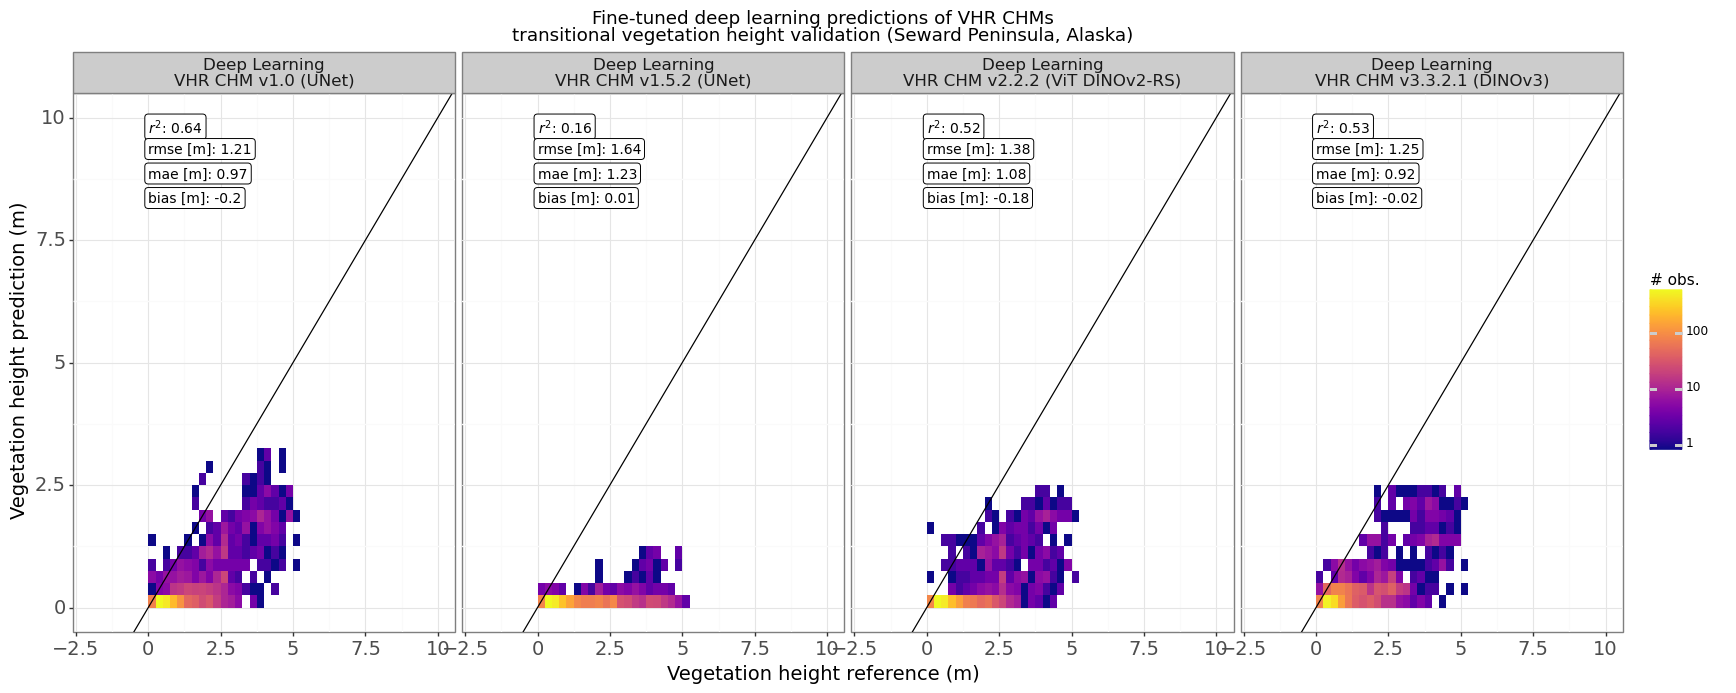

In [22]:
plotnine.options.figure_size = (20, 7)

LIST_ID_VARS = ['type_ref', 'source_type', 'source_extent',
                #'source_res', 
                #'source_temp_dif_ref',
                'source_cat'
               ]
#tmp_df = df[ df.source_type == 'VHR CHM v1.0 (UNet)' ]
tmp_df = df[ 
            #(df.source_type == 'VHR CHM v1.5.1 (UNet)') |
            (df.source_type == 'VHR CHM v1.5.2 (UNet)') | 
            (df.source_type == 'VHR CHM v1.0 (UNet)') | 
            #(df.source_type == 'VHR CHM v2.1 (ViT DINOv2)') | 
            #(df.source_type == 'VHR CHM v2.2.1 (ViT DINOv2-RS)') |
            (df.source_type == 'VHR CHM v2.2.2 (ViT DINOv2-RS)') | 
             #(df.source_type == 'VHR CHM v2.2.3 (ViT DINOv2-RS)') |
             #(df.source_type == 'VHR CHM v2.2.4 (ViT DINOv2-RS)')
            (df.source_type == 'VHR CHM v3.3.2.1 (DINOv3)')
            #(df.source_type == 'ATL03')  
           ]
tmp_df = tmp_df[ (tmp_df.type_ref == 'field 2m')]
tmp_df = tmp_df[ (tmp_df.source_res != '10m')]
tmp_df = tmp_df[ (tmp_df.source_type != 'UAV')] #rm the results from UAV DSM - UAV DTM - we now use UAV CHM gridded to 2m using MAX rule

#tmp_df[ (tmp_df.source_type == 'CHM v2.1')]['value'] = tmp_df[ (tmp_df.source_type == 'CHM v2.1')].value / 10
print(tmp_df.shape)
    
p = do_facet_plots(LIST_ID_VARS, tmp_df, 'source_cat + source_type', MAX_VAL=10) 
print(p)
#fig.savefig(os.path.join(OUTDIR_PLOTS, 'plot_validation_deep_learning_sewardfield.tif'), dpi=300)
#p.save(filename = os.path.join(OUTDIR_PLOTS, 'plot_validation_deep_learning_sewardfield.png'), width=14, height=6, units = 'in', dpi=300)

(8276, 23)
(4, 17)


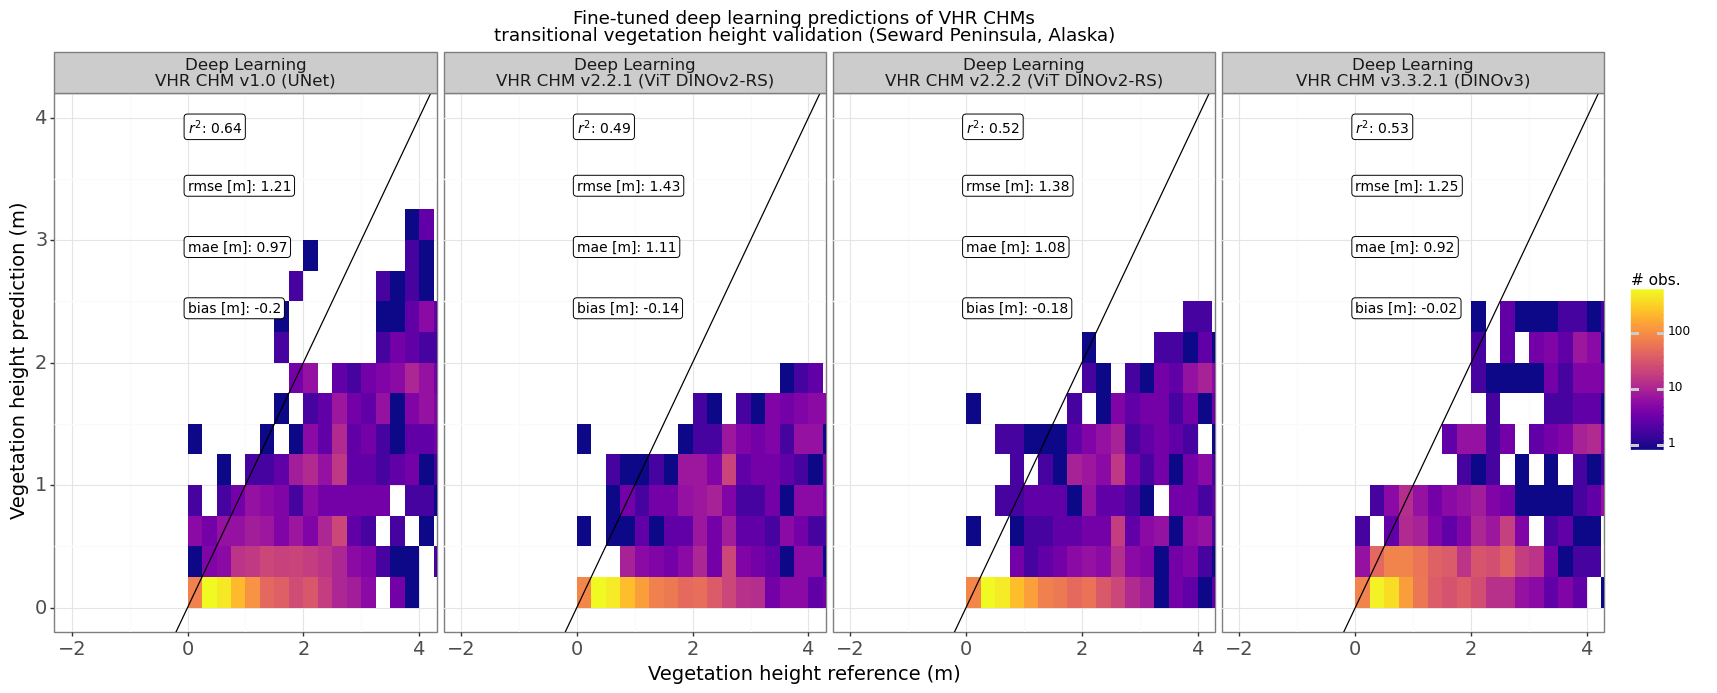

/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 14 x 6 in image.
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /explore/nobackup/projects/above/misc/ABoVE_Shrubs/plots/plot_validation_deep_learning_sewardfield.png


In [111]:
plotnine.options.figure_size = (20, 7)

LIST_ID_VARS = ['type_ref', 'source_type', 'source_extent',
                #'source_res', 
                #'source_temp_dif_ref',
                'source_cat']

tmp_df = df[ (df.source_type == 'VHR CHM v1.0 (UNet)') | 
            #(df.source_type == 'VHR CHM v2.1 (ViT DINOv2)') | 
            (df.source_type == 'VHR CHM v2.2.1 (ViT DINOv2-RS)') |
            (df.source_type == 'VHR CHM v2.2.2 (ViT DINOv2-RS)') | 
             #(df.source_type == 'VHR CHM v2.2.3 (ViT DINOv2-RS)') |
             #(df.source_type == 'VHR CHM v2.2.4 (ViT DINOv2-RS)')
            (df.source_type == 'VHR CHM v3.3.2.1 (DINOv3)')
            #(df.source_type == 'ATL03')  
           ]
tmp_df = tmp_df[ (tmp_df.type_ref == 'field 2m')]
tmp_df = tmp_df[ (tmp_df.source_res != '10m')]
tmp_df = tmp_df[ (tmp_df.source_type != 'UAV')] #rm the results from UAV DSM - UAV DTM - we now use UAV CHM gridded to 2m using MAX rule

#tmp_df[ (tmp_df.source_type == 'CHM v2.1')]['value'] = tmp_df[ (tmp_df.source_type == 'CHM v2.1')].value / 10
print(tmp_df.shape)
    
p = do_facet_plots(LIST_ID_VARS, tmp_df, 'source_cat + source_type', MAX_VAL=4) 
print(p)
#fig.savefig(os.path.join(OUTDIR_PLOTS, 'plot_validation_deep_learning_sewardfield.tif'), dpi=300)
p.save(filename = os.path.join(OUTDIR_PLOTS, 'plot_validation_deep_learning_sewardfield.png'), width=14, height=6, units = 'in', dpi=300)

(20, 18)


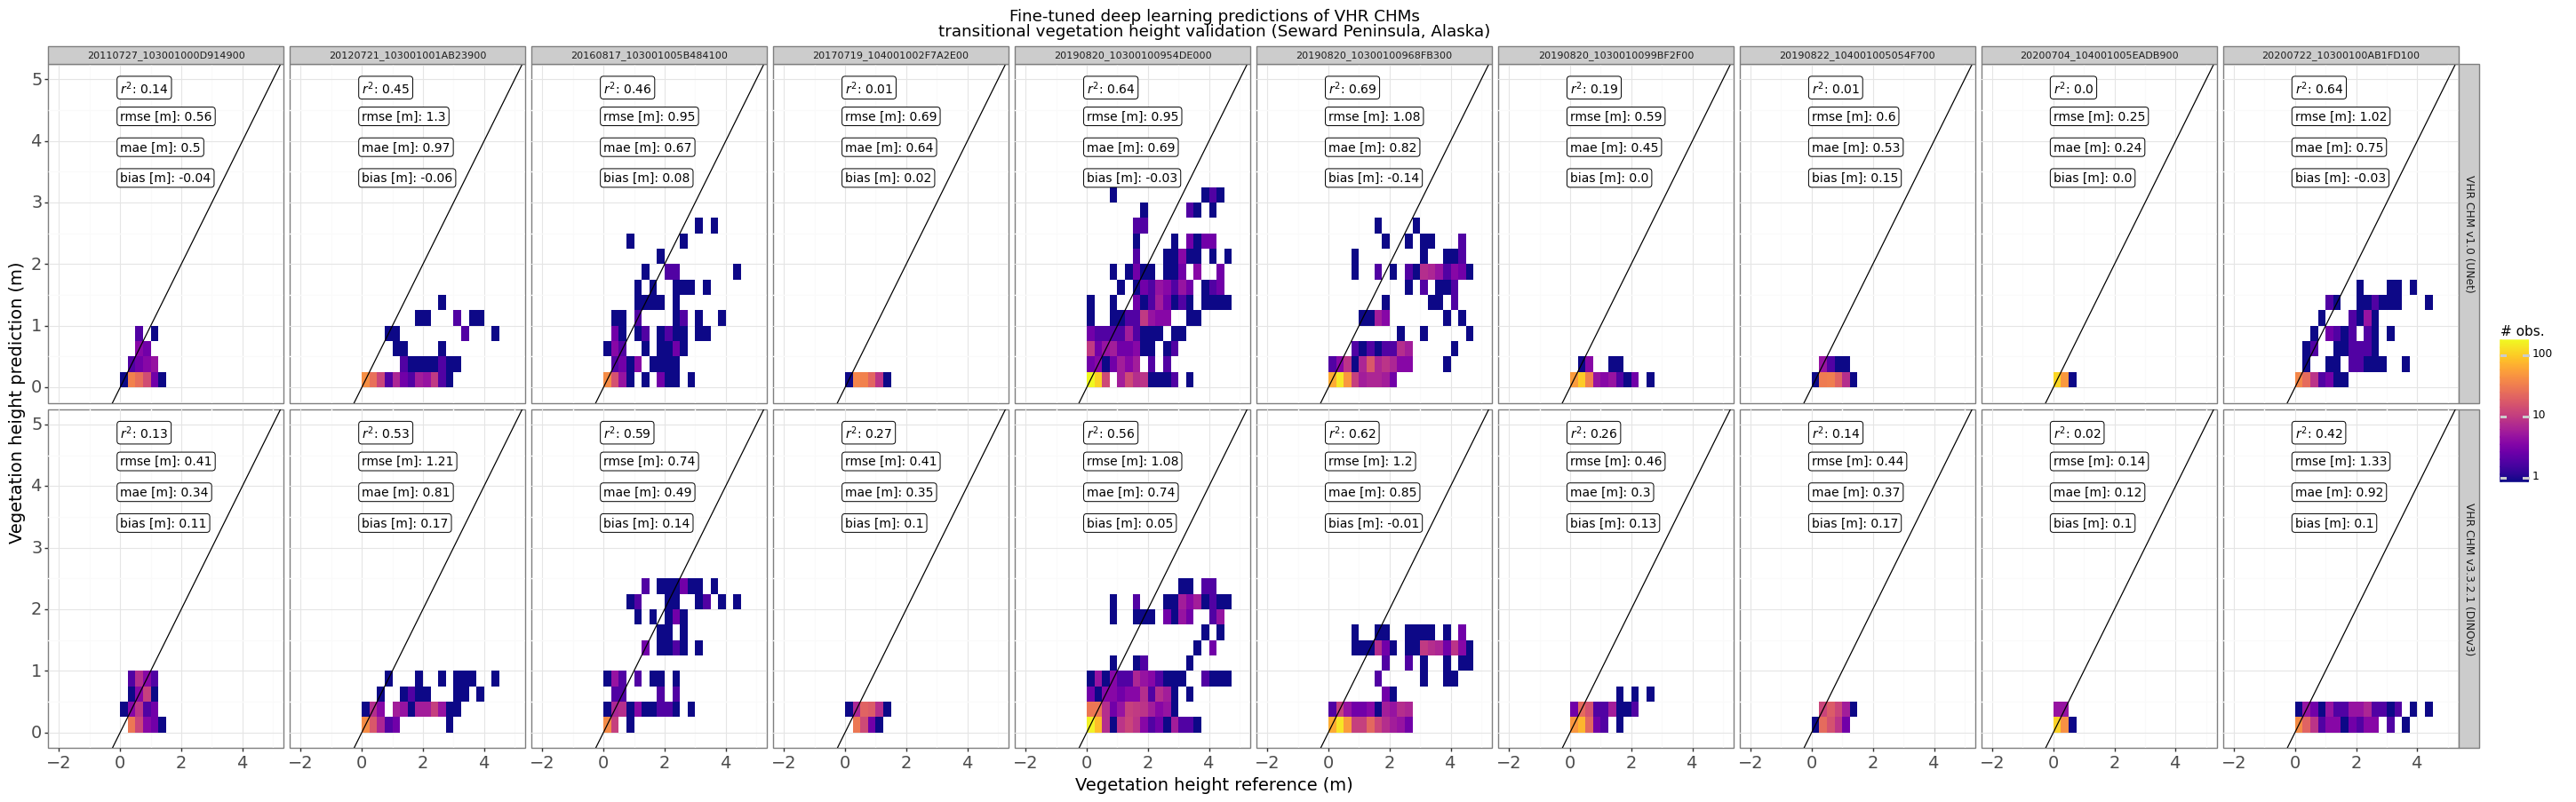

/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 20 x 7 in image.
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /explore/nobackup/projects/above/misc/ABoVE_Shrubs/plots/plot_validation_indiv_VHR_deep_learning_sewardfield.png


In [117]:
plotnine.options.figure_size = (35, 10)

LIST_ID_VARS = ['type_ref', 'source_type', 'source_extent', 'source_simple',
                #'source_res', 
                #'source_temp_dif_ref',
                'source_cat']

tmp_df = df[ (df.source_type == 'VHR CHM v1.0 (UNet)') | 
            (df.source_type == target_string) | 
            (df.source_type == 'VHR CHM v2.2 (ViT DINOv2-RS)') & 
            ~((df.source_type == 'VHR CHM v1.0 (UNet)') & (df.source_res =='10m'))
           ]
tmp_df = tmp_df[ (tmp_df.type_ref == 'field 0.3m')]
tmp_df = tmp_df[ (tmp_df.source_res != '10m')]
tmp_df = tmp_df[ (tmp_df.source_type != 'UAV')] #rm the results from UAV DSM - UAV DTM - we now use UAV CHM gridded to 2m using MAX rule

#tmp_df[ (tmp_df.source_type == 'CHM v2.1')]['value'] = tmp_df[ (tmp_df.source_type == 'CHM v2.1')].value / 10

    
p = do_facet_plots(LIST_ID_VARS, tmp_df, 'source_simple', 'source_type') + theme(strip_text_x = element_text(size=8))
print(p)
p.save(filename = os.path.join(OUTDIR_PLOTS, 'plot_validation_indiv_VHR_deep_learning_sewardfield.png'), width=20, height=7, units = 'in', dpi=600) #, limitsize=False)

In [113]:
tmp_df.source_type.unique()

array(['VHR CHM v1.0 (UNet)'], dtype=object)

In [114]:
tmp_df[LIST_ID_VARS+['height_ref', 'value']].dropna().groupby(LIST_ID_VARS).apply(validation_smry_stats, 'height_ref', 'value').dropna()

n  \
type_ref source_type         source_extent source_simple             source_cat             
field 2m VHR CHM v1.0 (UNet) Regional      20110727_103001000D914900 Deep Learning  100.0   
                                           20120721_103001001AB23900 Deep Learning  140.0   
                                           20160817_103001005B484100 Deep Learning  140.0   
                                           20170719_104001002F7A2E00 Deep Learning  100.0   
                                           20190820_10300100954DE000 Deep Learning  550.0   
                                           20190820_10300100968FB300 Deep Learning  450.0   
                                           20190820_1030010099BF2F00 Deep Learning  200.0   
                                           20190822_104001005054F700 Deep Learning  100.0   
                                           20200704_104001005EADB900 Deep Learning  150.0   
                                           20200722_10300100AB1FD100 Deep Learning  136.0   

                                                                                       slope  \
type_ref source_type         source_extent source_simple             source_cat                
field 2m VHR CHM v1.0 (UNet) Regional      20110727_103001000D914900 Deep Learning  0.351290   
                                           20120721_103001001AB23900 Deep Learning  0.179771   
                                           20160817_103001005B484100 Deep Learning  0.401199   
                                           20170719_104001002F7A2E00 Deep Learning -0.002521   
                                           20190820_10300100954DE000 Deep Learning  0.482299   
                                           20190820_10300100968FB300 Deep Learning  0.455381   
                                           20190820_1030010099BF2F00 Deep Learning  0.061193   
                                           20190822_104001005054F700 Deep Learning -0.056968   
                                           20200704_104001005EADB900 Deep Learning -0.000610   
                                           20200722_10300100AB1FD100 Deep Learning  0.334526   

                                                                                    intercept  \
type_ref source_type         source_extent source_simple             source_cat                 
field 2m VHR CHM v1.0 (UNet) Regional      20110727_103001000D914900 Deep Learning  -0.154428   
                                           20120721_103001001AB23900 Deep Learning  -0.128886   
                                           20160817_103001005B484100 Deep Learning  -0.065376   
                                           20170719_104001002F7A2E00 Deep Learning   0.017714   
                                           20190820_10300100954DE000 Deep Learning  -0.151721   
                                           20190820_10300100968FB300 Deep Learning  -0.285264   
                                           20190820_1030010099BF2F00 Deep Learning  -0.011634   
                                           20190822_104001005054F700 Deep Learning   0.173573   
                                           20200704_104001005EADB900 Deep Learning   0.004880   
                                           20200722_10300100AB1FD100 Deep Learning  -0.120474   

                                                                                     r_value  \
type_ref source_type         source_extent source_simple             source_cat                
field 2m VHR CHM v1.0 (UNet) Regional      20110727_103001000D914900 Deep Learning  0.488242   
                                           20120721_103001001AB23900 Deep Learning  0.751200   
                                           20160817_103001005B484100 Deep Learning  0.763316   
                                           20170719_104001002F7A2E00 Deep Learning -0.107125   
                                           20190820_10300100954DE000 Deep Lea

/explore/nobackup/people/pmontesa/.nccstmp/ipykernel_3802594/1991113576.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_bin_2d : Removed 4 rows containing non-finite values.


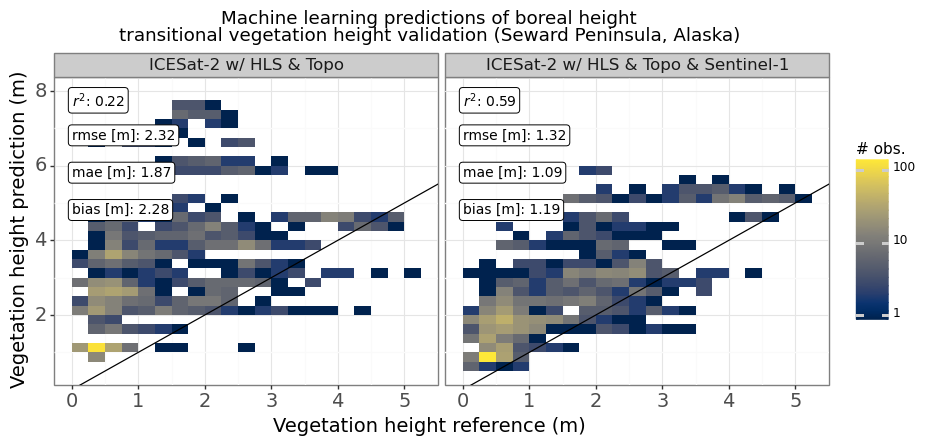

/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 14 x 6 in image.
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /explore/nobackup/projects/above/misc/ABoVE_Shrubs/plots/plot_validation_indiv_NASA_Circumboreal_sewardfield.png
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_bin_2d : Removed 4 rows containing non-finite values.


In [115]:
plotnine.options.figure_size = (10, 4)

LIST_ID_VARS = ['type_ref', 
                'source_type', 
                #'source_extent'
                #'source_res', 
                #'source_temp_dif_ref',
                #'source_cat'
               ]

tmp_df = df[ (df.source_type == 'NASA|UMd HLS') | 
            (df.source_type == 'NASA|UMd S1+HLS')   
           ]

# Rename source type
tmp_df['source_type'] = pd.Series(tmp_df['source_type'], dtype="category").cat.rename_categories(
    {'NASA|UMd HLS':   'ICESat-2 w/ HLS & Topo', 
    'NASA|UMd S1+HLS': 'ICESat-2 w/ HLS & Topo & Sentinel-1'})

tmp_df = tmp_df[ (tmp_df.type_ref == 'field 2m')]
#tmp_df = tmp_df[ (tmp_df.source_res != '10m')]
tmp_df = tmp_df[ (tmp_df.source_type != 'UAV')] #rm the results from UAV DSM - UAV DTM - we now use UAV CHM gridded to 2m using MAX rule

#tmp_df[ (tmp_df.source_type == 'CHM v2.1')]['value'] = tmp_df[ (tmp_df.source_type == 'CHM v2.1')].value / 10
# Run the validation stats
smry = round(tmp_df[LIST_ID_VARS+['height_ref', 'value']].dropna().groupby(LIST_ID_VARS).apply(validation_smry_stats, 'height_ref', 'value').reset_index() , 2).dropna()
smry['r2_value'] = round(smry['r_value'] * smry['r_value'], 2)
smry['r2_value_str'] = f"$r^2$: " + smry['r2_value'].astype(str)
smry['rmse_str'] = f"rmse [m]: " + smry['rmse'].astype(str)
smry['mae_str'] = f"mae [m]: " + smry['mae'].astype(str)
smry['bias_str'] = f"bias [m]: " + smry['intercept'].astype(str)

max_val = 8
lab_sz = 10
p = (
    ggplot(tmp_df
           , aes(y='value', x='height_ref'))
    + labs(x = 'Vegetation height reference (m)', y= 'Vegetation height prediction (m)', title='Machine learning predictions of boreal height\ntransitional vegetation height validation (Seward Peninsula, Alaska)')
    + geom_bin2d(binwidth=0.25)
        #+ geom_point(aes(group='type'), size=0.75, alpha=0.01)
    + geom_abline()
         + geom_label(data=smry, mapping=aes(x=0, y=max_val, label='r2_value_str'), ha='left', va='top', size=lab_sz)
         + geom_label(data=smry, mapping=aes(x=0, y=max_val-1, label='rmse_str'), ha='left', va='top', size=lab_sz)
         + geom_label(data=smry, mapping=aes(x=0, y=max_val-2, label='mae_str'), ha='left', va='top', size=lab_sz)
         + geom_label(data=smry, mapping=aes(x=0, y=max_val-3, label='bias_str'), ha='left', va='top', size=lab_sz)
        #+ coord_cartesian(ylim=(0,max_val), xlim=(-2,max_val))
        + scale_fill_cmap(cmap_name='cividis', trans='log10', name='# obs.')
        
        #+ facet_grid(f'. ~ {FACET_VAR}')
        #+ facet_grid(f'{FACET_VAR_LIST[0]} ~ {FACET_VAR_LIST[1]}')
    # + scale_fill_cmap(name = "count", trans = "log", cmap_name = 'plasma',
    #                     breaks = [1, 10,25,50,150,500], labels = [1, 10,25,50,150,500]
    #               )
    + facet_grid('. ~ source_type')
    + theme_bw() 
    #+ coord_equal(xlim = (0,100), ylim = (0,100))
    + theme(strip_text_x = element_text(size=12), axis_text = element_text(size=14), axis_title = element_text(size=14))
    + guides(color = guide_legend(override_aes = {'size' : 4, 'alpha': 1}))
)
#p = do_facet_plots(LIST_ID_VARS, tmp_df[LIST_ID_VARS+['height_ref', 'value']].dropna(), 'source_type')
print(p)
p.save(filename = os.path.join(OUTDIR_PLOTS, 'plot_validation_indiv_NASA_Circumboreal_sewardfield.png'), width=14, height=6, units = 'in', dpi=300, limitsize=False)

In [1]:
plotnine.options.figure_size = (40, 5)

LIST_ID_VARS = [
    'type_ref', 
    'source_type', 'source_extent'
]

tmp_df = df[ (df.type_ref == 'field 0.3m') &
            (df.source_type != 'VHR CHM v2.1 (ViT DINOv2)') & 
            (df.source_type != 'VHR CHM v2.1 (ViT DINOv2)') & 
            ~((df.source_type == 'VHR CHM v1.0 (UNet)') & (df.source_res =='10m'))
           ]
#tmp_df = tmp_df[ (tmp_df.source_res != '10m')]
tmp_df = tmp_df[ (tmp_df.source_type != 'UAV')]

# Run the validation stats
smry = round(tmp_df[LIST_ID_VARS+['height_ref', 'value']].dropna().groupby(LIST_ID_VARS).apply(validation_smry_stats, 'height_ref', 'value').reset_index() , 2).dropna()
smry['r2_value'] = round(smry['r_value'] * smry['r_value'], 2)
smry['r2_value_str'] = f"$r^2$: " + smry['r2_value'].astype(str)
smry['rmse_str'] = f"rmse [m]: " + smry['rmse'].astype(str)
smry['mae_str'] = f"mae [m]: " + smry['mae'].astype(str)
smry['bias_str'] = f"bias [m]: " + smry['intercept'].astype(str)

max_val = 10
lab_sz = 10
p = (
    ggplot(tmp_df
           , aes(y='value', x='height_ref'))
    + labs(x = 'Vegetation height reference (m)', y= 'Vegetation height prediction (m)', title='Multi-source predictions of boreal height\ntransitional vegetation height validation (Seward Peninsula, Alaska)')
    + geom_bin2d(binwidth=0.25)
        #+ geom_point(aes(group='type'), size=0.75, alpha=0.01)
    + geom_abline()
        + geom_label(data=smry, mapping=aes(x=5, y=max_val, label='r2_value_str'), ha='right', va='top', size=lab_sz)
        + geom_label(data=smry, mapping=aes(x=5, y=max_val-1, label='rmse_str'), ha='right', va='top', size=lab_sz)
        + geom_label(data=smry, mapping=aes(x=5, y=max_val-2, label='mae_str'), ha='right', va='top', size=lab_sz)
        + geom_label(data=smry, mapping=aes(x=5, y=max_val-3, label='bias_str'), ha='right', va='top', size=lab_sz)
        #+ coord_cartesian(ylim=(0,max_val), xlim=(-2,max_val))
        + scale_fill_cmap(cmap_name='plasma', trans='log10', name='# obs.')
        
        #+ facet_grid(f'. ~ {FACET_VAR}')
        #+ facet_grid(f'{FACET_VAR_LIST[0]} ~ {FACET_VAR_LIST[1]}')
    # + scale_fill_cmap(name = "count", trans = "log", cmap_name = 'plasma',
    #                     breaks = [1, 10,25,50,150,500], labels = [1, 10,25,50,150,500]
    #               )
    + facet_wrap('. ~ ' + '+'.join(reversed(LIST_ID_VARS[1:])))
    + theme_bw() 
    + coord_equal(xlim = (0,5), ylim = (0,10))
    + theme(strip_text_x = element_text(size=8), axis_text = element_text(size=14), axis_title = element_text(size=14))
    + guides(color = guide_legend(override_aes = {'size' : 4, 'alpha': 1}))
)
#p = do_facet_plots(LIST_ID_VARS, tmp_df[LIST_ID_VARS+['height_ref', 'value']].dropna(), '+'.join(reversed(LIST_ID_VARS[1:]))) + coord_equal(xlim = (0,5), ylim = (0,10))
print(p)
p.save(filename = os.path.join(OUTDIR_PLOTS, 'plot_validation_all_sewardfield.png'), width=24, height=5, units = 'in', dpi=300)

NameError: name 'plotnine' is not defined

In [122]:
plotnine.options.figure_size = (22, 5)


LIST_ID_VARS = ['type_ref', 'source_extent','source_type', 'source_res', 'source_temp_dif_ref','source_cat']

tmp_df = df[(df.source_type != 'VHR CHM v2.1 (ViT DINOv2)')]
tmp_df = tmp_df[(tmp_df.source_type != 'UAV')]
tmp_df = tmp_df[(tmp_df.type_ref != 'field 0.3m')]

#tmp_df = tmp_df[(tmp_df.type_ref != 'field 0.3m')]

# Run the validation stats
smry = round(tmp_df[LIST_ID_VARS+['height_ref', 'value']].dropna().groupby(LIST_ID_VARS).apply(validation_smry_stats, 'height_ref', 'value').reset_index() , 2)
smry['r2_value'] = round(smry['r_value'] * smry['r_value'], 2)
smry['r2_value_str'] = f"$r^2$: " + smry['r2_value'].astype(str)
smry['rmse_str'] = f"rmse [m]: " + smry['rmse'].astype(str)
smry['mae_str'] = f"mae [m]: " + smry['mae'].astype(str)
smry['bias_str'] = f"bias [m]: " + smry['intercept'].astype(str)
#smry['variable'] = smry['variable'].apply(lambda x: x.split('_')[-1])
max_val = 10
lab_sz = 3
# (
#     ggplot(tmp_df
#            , aes(y='value', x='height_ref'))
#     + labs(x = 'Vegetation height ref (m)', y= 'Vegetation height prediction (m)', caption='Transitional vegetation height validation: Seward Peninsula AK')
#     + geom_bin2d(binwidth=0.25)
#         #+ geom_point(aes(group='type'), size=0.75, alpha=0.01)
#     + geom_abline()
#         # + geom_label(data=smry, mapping=aes(x=0, y=max_val, label='r2_value_str'), ha='left', va='top', size=lab_sz)
#         # + geom_label(data=smry, mapping=aes(x=0, y=max_val-4, label='rmse_str'), ha='left', va='top', size=lab_sz)
#         # + geom_label(data=smry, mapping=aes(x=0, y=max_val-8, label='mae_str'), ha='left', va='top', size=lab_sz)
#         # + geom_label(data=smry, mapping=aes(x=0, y=max_val-12, label='bias_str'), ha='left', va='top', size=lab_sz)
#         # + coord_cartesian(ylim=(0,max_val), xlim=(-2,max_val))
#         + scale_fill_cmap(cmap_name='plasma', trans='log10', name='# obs.')
        
#         #+ facet_grid(f'. ~ {FACET_VAR}')
#         #+ facet_grid(f'{FACET_VAR_LIST[0]} ~ {FACET_VAR_LIST[1]}')
#     # + scale_fill_cmap(name = "count", trans = "log", cmap_name = 'plasma',
#     #                     breaks = [1, 10,25,50,150,500], labels = [1, 10,25,50,150,500]
#     #               )
#    # + facet_grid('. ~ source_extent + source_type + source_res')
#    # + facet_wrap('~ source_extent + source_type + source_res', ncol=5)
#     #+ facet_grid('source_cat ~ source_extent')
#     + facet_grid('source_cat ~ source_extent + source_type')
#     #+ coord_cartesian(xlim = (0,10), ylim = (0,10))
#     + theme_bw() 
#     + coord_equal(xlim = (0,10), ylim = (0,10))
#     + theme(strip_text_x = element_text(size=10))
#     + guides(color = guide_legend(override_aes = {'size' : 4, 'alpha': 1}))
# )

In [123]:
smry[~((smry.source_type == 'VHR CHM v1.0 (UNet)') & (smry.source_res =='10m'))].dropna()

,type_ref,source_extent,source_type,source_res,source_temp_dif_ref,source_cat,n,slope,intercept,r_value,...,expvarscore,mae,mse,rmse,medae,r2_value,r2_value_str,rmse_str,mae_str,bias_str
554,field 2m,Global,Pub: Lang et al. 2023,10m,4 yr dif,Deep Learning,1137.0,1.17,5.71,0.49,...,-3.40,5.96,40.88,6.39,5.61,0.24,$r^2$: 0.24,rmse [m]: 6.39,mae [m]: 5.96,bias [m]: 5.71
733,field 2m,Global,Pub: Potapov et al. 2021,30m,5 yr dif,Machine Learning,1138.0,3.20,-1.57,0.54,...,-28.18,3.40,38.14,6.18,0.98,0.29,$r^2$: 0.29,rmse [m]: 6.18,mae [m]: 3.4,bias [m]: -1.57
773,field 2m,Global,Pub: Tolan et al. 2024,2m,4-7 yr dif,Deep Learning,1138.0,0.31,-0.24,0.60,...,0.35,1.21,2.25,1.50,0.90,0.36,$r^2$: 0.36,rmse [m]: 1.5,mae [m]: 1.21,bias [m]: -0.24
2233,field 2m,Circumpolar,NASA|UMd HLS,30m,4 yr dif,Machine Learning,1138.0,0.67,2.28,0.47,...,-0.70,1.87,5.39,2.32,1.72,0.22,$r^2$: 0.22,rmse [m]: 2.32,mae [m]: 1.87,bias [m]: 2.28
2359,field 2m,Circumpolar,NASA|UMd S1+HLS,30m,4 yr dif,Machine Learning,1138.0,0.88,1.19,0.77,...,0.44,1.09,1.75,1.32,0.92,0.59,$r^2$: 0.59,rmse [m]: 1.32,mae [m]: 1.09,bias [m]: 1.19
4676,field 2m,Regional,VHR CHM v1.0 (UNet),2m,4-14 yr dif,Deep Learning,2066.0,0.42,-0.20,0.80,...,0.56,0.97,1.47,1.21,0.70,0.64,$r^2$: 0.64,rmse [m]: 1.21,mae [m]: 0.97,bias [m]: -0.2
4865,field 2m,Regional,VHR CHM v1.5.1 (UNet),2m,4-14 yr dif,Deep Learning,1930.0,0.06,0.01,0.45,...,0.10,1.19,2.55,1.60,0.75,0.20,$r^2$: 0.2,rmse [m]: 1.6,mae [m]: 1.19,bias [m]: 0.01
4991,field 2m,Regional,VHR CHM v1.5.2 (UNet),2m,4-14 yr dif,Deep Learning,2070.0,0.05,0.01,0.40,...,0.08,1.23,2.68,1.64,0.76,0.16,$r^2$: 0.16,rmse [m]: 1.64,mae [m]: 1.23,bias [m]: 0.01
5117,field 2m,Regional,VHR CHM v2.2.1 (ViT DINOv2-RS),2m,4-14 yr dif,Deep Learning,2070.0,0.25,-0.14,0.70,...,0.37,1.11,2.04,1.43,0.75,0.49,$r^2$: 0.49,rmse [m]: 1.43,mae [m]: 1.11,bias [m]: -0.14
5243,field 2m,Regional,VHR CHM v2.2.2 (ViT DINOv2-RS),2m,4-14 yr dif,Deep Learning,2070.0,0.31,-0.18,0.72,...,0.43,1.08,1.89,1.38,0.75,0.52,$r^2$: 0.52,rmse [m]: 1.38,mae [m]: 1.08,bias [m]: -0.18


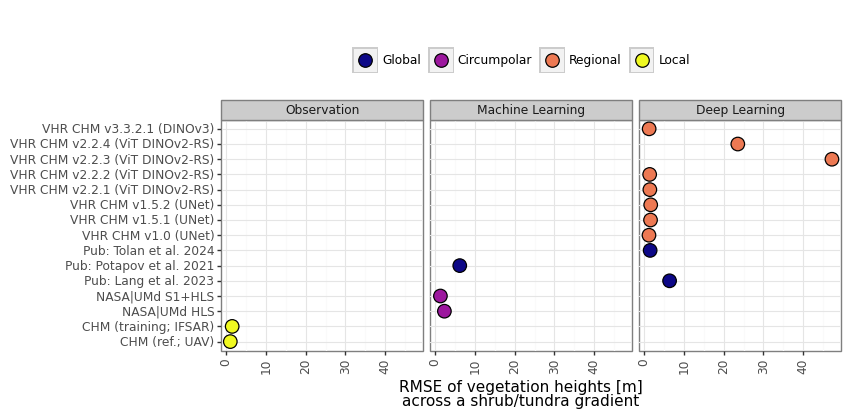

/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 3 in image.
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /explore/nobackup/projects/above/misc/ABoVE_Shrubs/plots/plot_validation_all_sewardfield_smry.png


In [124]:
plotnine.options.figure_size = (8, 3)
smry = smry[~((smry.source_type == 'VHR CHM v1.0 (UNet)') & (smry.source_res =='10m'))]
smry['source_type'] = pd.Categorical(smry['source_type'])
# rmse_means = smry.groupby('source_type')['rmse'].mean()
# smry['source_type'] = smry['source_type'].cat.reorder_categories(rmse_means.sort_values().index)

p = (
    ggplot(smry.dropna(), aes(y='source_type', x='rmse'))
    + geom_point( aes(fill='source_extent')
                 , color='black'
                 , shape='o'
                 #, fill="none"
                 , size=5, stroke=0.5, alpha=1)
    #+ scale_fill_brewer(type='qual')
    + scale_fill_cmap_d(name='plasma')
    + facet_wrap('~source_cat')
    + labs(x='RMSE of vegetation heights [m]\nacross a shrub/tundra gradient')
    + theme_bw()
    + theme(axis_text_x = element_text(angle=90), legend_position = 'top', legend_direction='horizontal', )
    + labs(fill='', y='')
)
print(p)
p.save(filename = os.path.join(OUTDIR_PLOTS, 'plot_validation_all_sewardfield_smry.png'), width=10, height=3, units = 'in', dpi=300)

/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_bin_2d : Removed 58 rows containing non-finite values.


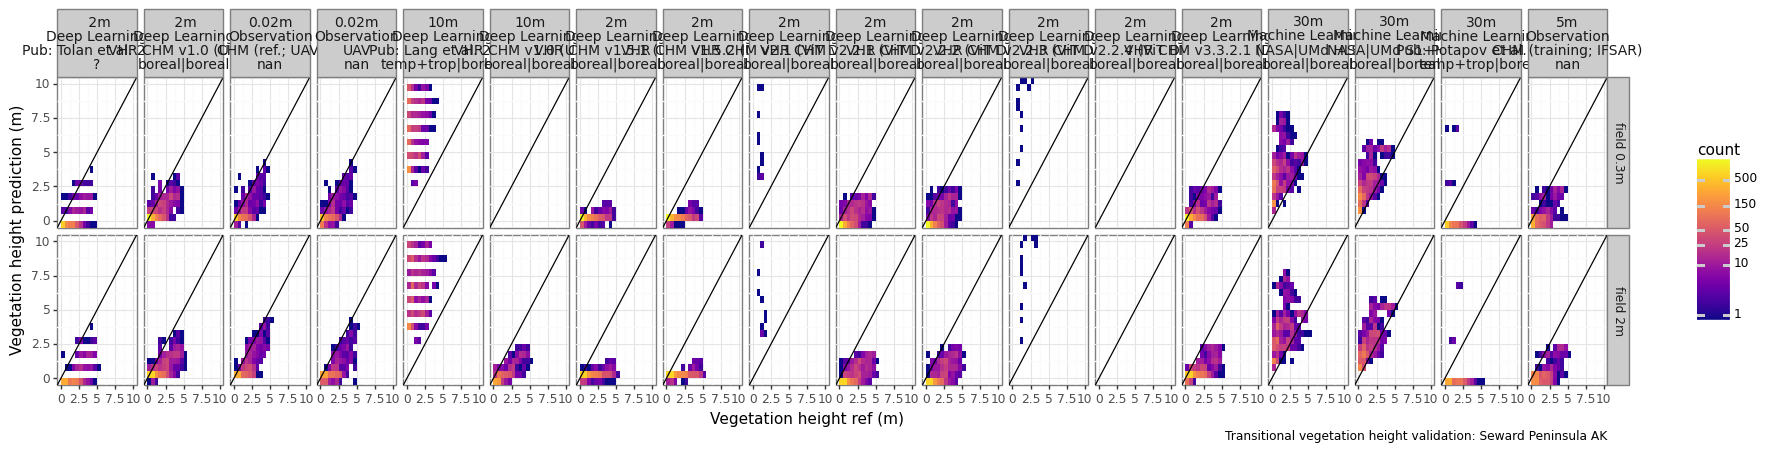

<ggplot: (1460609334757)>

In [125]:
plotnine.options.figure_size = (20, 4)

(
    ggplot(
        df
        #all_ref_m[(all_ref_m.value > -9999) & (all_ref_m.value < 50) & (all_ref_m.height_ref < 100 ) ]
        , aes(y='value', x='height_ref'))
    + labs(x = 'Vegetation height ref (m)', y= 'Vegetation height prediction (m)', caption='Transitional vegetation height validation: Seward Peninsula AK')
    + geom_bin2d(binwidth=0.5)
        #+ geom_point(aes(group='type'), size=0.75, alpha=0.01)
    + geom_abline()
    + scale_fill_cmap(name = "count", trans = "log", cmap_name = 'plasma',
                        breaks = [1, 10,25,50,150,500], labels = [1, 10,25,50,150,500]
                  )
    + facet_grid('type_ref ~ source_res + source_cat + source_type + source_mod_dev_app_class')
    + coord_cartesian(xlim = (0,10), ylim = (0,10))
    + theme_bw() 
    #+ coord_equal()
    + theme(strip_text_x = element_text(size=10))
    + guides(color = guide_legend(override_aes = {'size' : 4, 'alpha': 1}))
)

### Exploratory plots at sites with various RS and ATL03 photon classes

In [16]:
class_color_list
class_name_list

['Top of canopy', 'Canopy', 'Ground']

In [17]:
df.color.unique()
#list(reversed(class_color_list[0:2]))

array(['darkgreen', 'lightgreen'], dtype=object)

In [18]:
#custom_color_atl03 = scale_color_manual(values = class_color_list[1:]+class_color_list[0:1], labels=class_name_list[1:]+class_name_list[0:1], name='Photon class')
custom_color_atl03 = scale_color_manual(values = list(reversed(class_color_list[0:2])), labels=list(reversed(class_name_list[0:2])), name='Photon class')

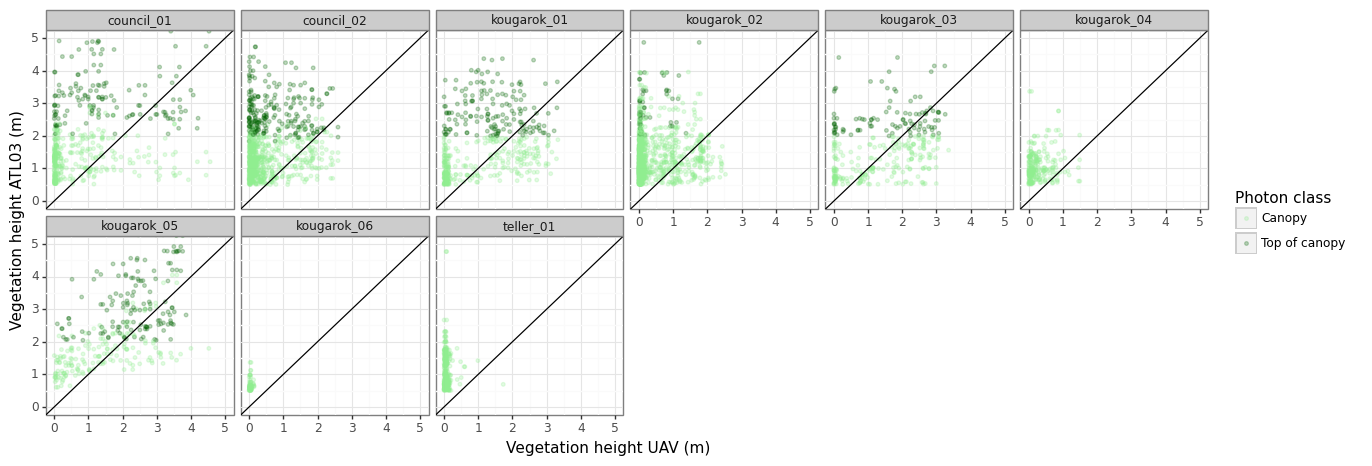

<ggplot: (1413359060592)>

In [19]:
plotnine.options.figure_size = (15, 5)

(
      ggplot(
              df[(df.type_ref == 'ATL03') & (df.source_type == 'UAV CHM') & (df.value !=-10000)],
             aes(y='height_ref', x='value'))
        + labs(x = 'Vegetation height UAV (m)', y= 'Vegetation height ATL03 (m)')
        #+ geom_bin2d(binwidth=0.2)
        + custom_color_atl03
        + geom_point(aes(color='class_name', group='class_name'), size=1, alpha=0.25)
        + geom_abline()
        + facet_wrap(' ~ site', ncol=6)#, scales = 'free_x')
    + coord_cartesian(xlim = (0,5), ylim = (0,5))
    + theme_bw() 
)

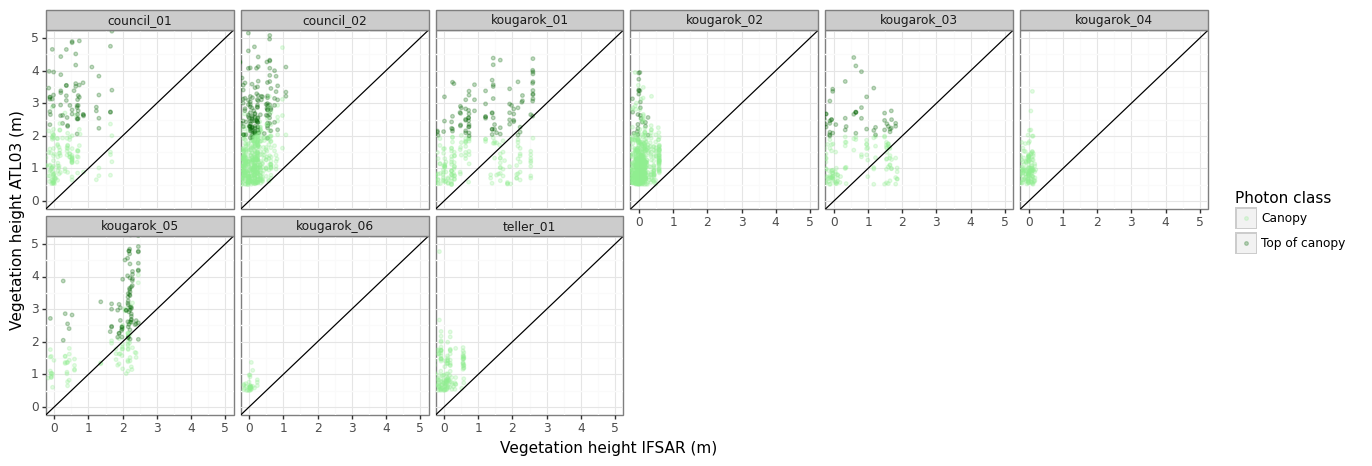

<ggplot: (1413358657835)>

In [20]:
plotnine.options.figure_size = (15, 5)

(
      ggplot(
          #all_ref_gdf_extract[(all_ref_gdf_extract.dsm_uav !=-10000) & (all_ref_gdf_extract.type_ref == 'ATL03')],
                  df[(df.type_ref == 'ATL03') & (df.source_type == 'IFSAR') & (df.value !=-10000)],
                 aes(y='height_ref', x='value'))
        + labs(x = 'Vegetation height IFSAR (m)', y= 'Vegetation height ATL03 (m)')
        #+ geom_bin2d(binwidth=0.2)
        + custom_color_atl03
        + geom_point(aes(color='class_name', group='class_name'), size=1, alpha=0.25)
        + geom_abline()
        + facet_wrap(' ~ site', ncol=6)#, scales = 'free_x')
    + coord_cartesian(xlim = (0,5), ylim = (0,5))
    + theme_bw() 
)

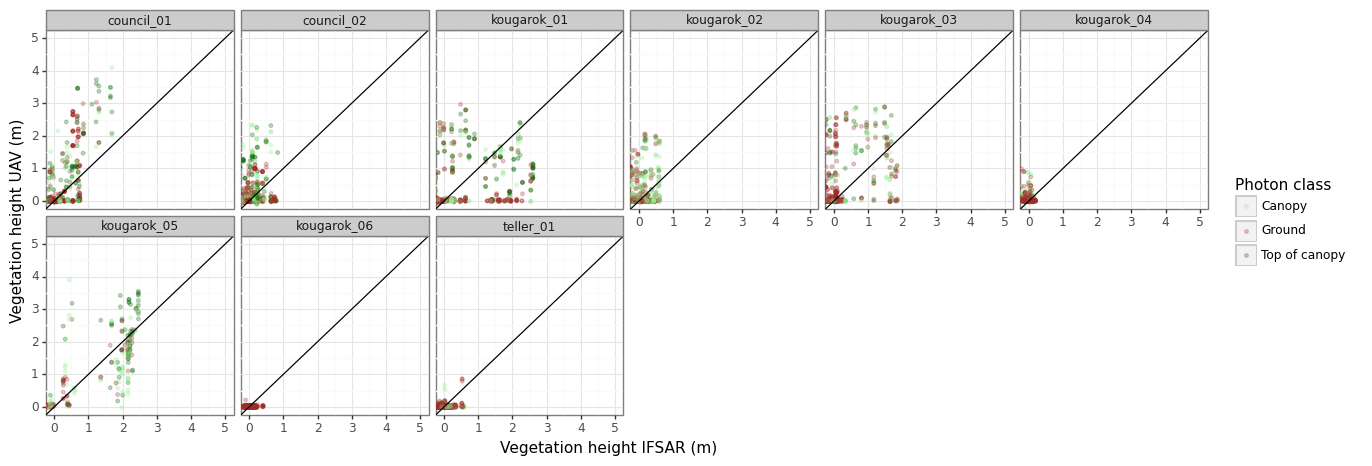

<ggplot: (1435783069648)>

In [142]:
plotnine.options.figure_size = (15, 5)

(
      ggplot(
          df[(all_ref_gdf_extract.dsm_uav !=-10000) & (all_ref_gdf_extract.type_ref == 'ATL03')], aes(y='ht_uav', x='ht_ifsar'))
        + labs(x = 'Vegetation height IFSAR (m)', y= 'Vegetation height UAV (m)')
        #+ geom_bin2d(binwidth=0.2)
        + custom_color_atl03
        + geom_point(aes(color='class_name', group='class_name'), size=1, alpha=0.25)
        + geom_abline()
        + facet_wrap(' ~ site', ncol=6)#, scales = 'free_x')
    + coord_cartesian(xlim = (0,5), ylim = (0,5))
    + theme_bw() 
)

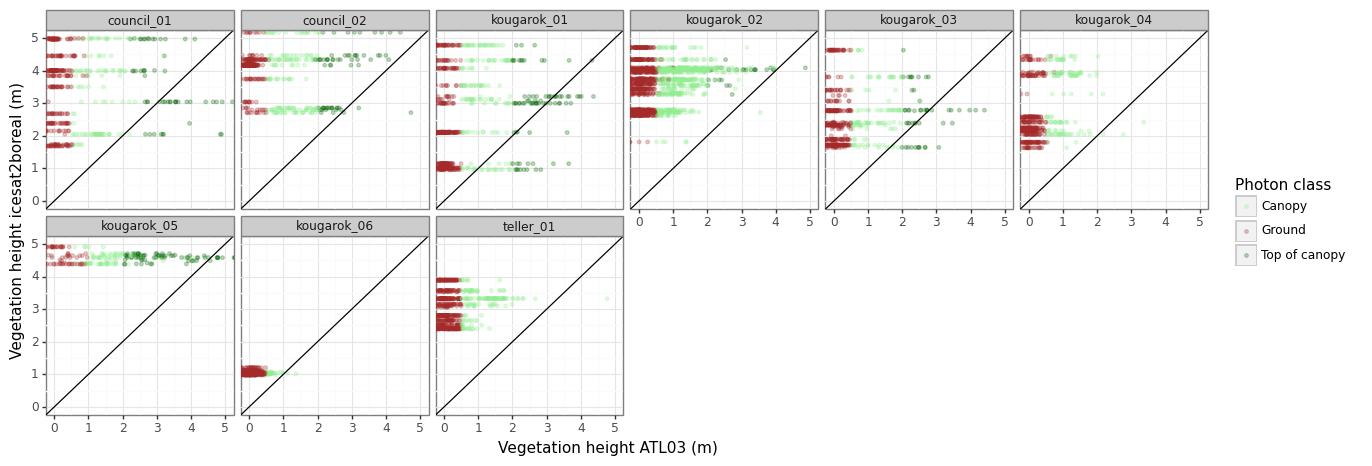

<ggplot: (1435887062176)>

In [145]:
plotnine.options.figure_size = (15, 5)

(
      ggplot(all_ref_gdf_extract[(all_ref_gdf_extract.dsm_uav !=-10000) & (all_ref_gdf_extract.type_ref == 'ATL03')], aes(y='ht_icesat2boreal', x='height_ref'))
        + labs(x = 'Vegetation height ATL03 (m)', y= 'Vegetation height icesat2boreal (m)')
        #+ geom_bin2d(binwidth=0.2)
        + custom_color_atl03
        + geom_point(aes(color='class_name', group='class_name'), size=1, alpha=0.25)
        + geom_abline()
        + facet_wrap(' ~ site', ncol=6)#, scales = 'free_x')
    + coord_cartesian(xlim = (0,5), ylim = (0,5))
    + theme_bw() 
)

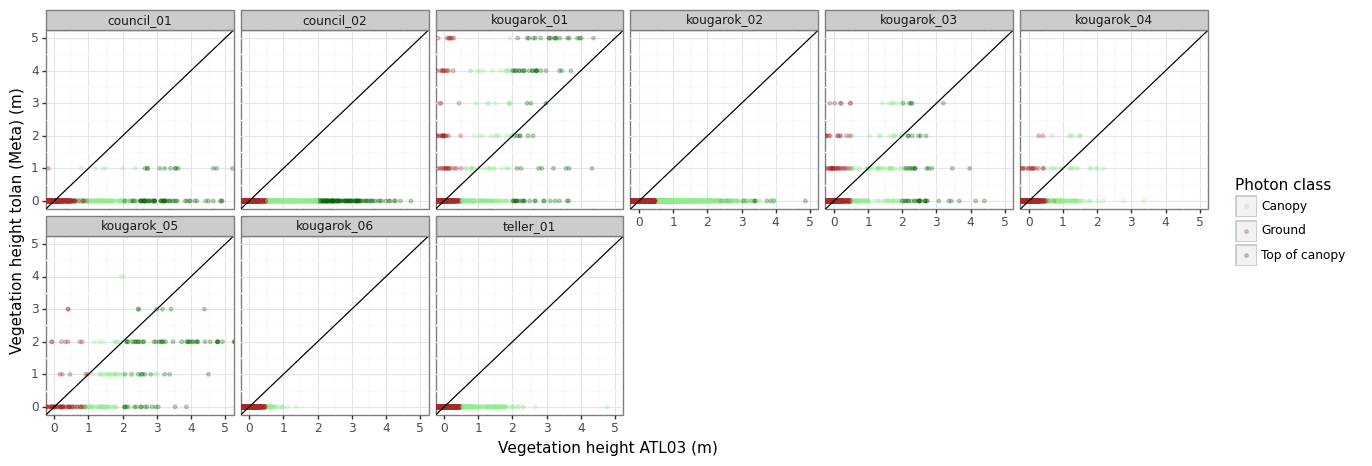

<ggplot: (1435779373873)>

In [146]:
plotnine.options.figure_size = (15, 5)

(
      ggplot(all_ref_gdf_extract[(all_ref_gdf_extract.dsm_uav !=-10000) & (all_ref_gdf_extract.type_ref == 'ATL03')], aes(y='ht_tolan', x='height_ref'))
        + labs(x = 'Vegetation height ATL03 (m)', y= 'Vegetation height tolan (Meta) (m)')
        #+ geom_bin2d(binwidth=0.2)
        + custom_color_atl03
        + geom_point(aes(color='class_name', group='class_name'), size=1, alpha=0.25)
        + geom_abline()
        + facet_wrap(' ~ site', ncol=6)#, scales = 'free_x')
    + coord_cartesian(xlim = (0,5), ylim = (0,5))
    + theme_bw() 
)

## Plot transects of height & elevation by site
#### TODO: shift ATL08 to align correctly with ATL03 along the transect
#### TODO: put UAV into same vertical datum as ICESat-2
#### TODO: find missing ATL08 30 for a couple lines

In [ ]:
import plotlib
import importlib
importlib.reload(plotlib)

In [ ]:
cols = ['class_name','color']
all_ref_gdf_extract[cols] = all_ref_gdf_extract[cols].astype('category')
all_ref_gdf_extract['class'] = all_ref_gdf_extract['class'].astype('int8')

In [ ]:
#all_ref_gdf_extract.head()

In [ ]:
for site in reversed(all_ref_gdf_extract.site.unique()):
    print(site)
    # Remove rows where dsm values are NA
    #atl03_TMP = atl03_field_gdf[atl03_field_gdf.dsm_uav != -10000]
    plotlib.plot_atl03_transect(start=0, transect_length=50000, DO_HEIGHT=True, 
                                atl03_gdf = all_ref_gdf_extract[(all_ref_gdf_extract.type_ref == 'ATL03') & (all_ref_gdf_extract.site == site) & (all_ref_gdf_extract.dsm_uav != -10000)], 
                                atl08_100m_gdf=None, #all_ref_gdf_extract[(all_ref_gdf_extract.type_ref == 'ATL08') & (all_ref_gdf_extract.site == site) ],#& (atl08_field_gdf_extract.dsm_uav != -10000)], 
                                atl08_30m_gdf=all_ref_gdf_extract[(all_ref_gdf_extract.type_ref == 'ATL08 30m') & (all_ref_gdf_extract.site == site) ],#& (atl08_30m_field_gdf_extract.dsm_uav != -10000)], 
                                footprint_uav_gdf=footprint_uav_gdf[footprint_uav_gdf.site == site],
                               site=site, PLOT_UAV=True, 
                                HEIGHT_COLS = ['ht_ifsar','ht_tolan','ht_nasa_cnn_10m'],#['ht_icesat2boreal','ht_ifsar','ht_tolan','ht_nasa_cnn_10m'],
                        COL_ATL03_HT='height_ref',
                        COL_UAV_HT='ht_uav',
                        COL_DSM_UAV='dsm_uav',
                        COL_ATL08_HT='height_ref',
                        COL_ATL08_ELEV='elev',
                           COL_PH_CLASS='class'
                               )

In [131]:
for site in reversed(atl03_field_gdf.site.unique()):
    print(site)
    # Remove rows where dsm values are NA
    #atl03_TMP = atl03_field_gdf[atl03_field_gdf.dsm_uav != -10000]
    plotlib.plot_atl03_transect(start=0, transect_length=50000, DO_HEIGHT=False, 
                                atl03_gdf=atl03_field_gdf_extract[(atl03_field_gdf_extract.site == site) & (atl03_field_gdf_extract.dsm_uav != -10000)], 
                                atl08_100m_gdf=atl08_field_gdf_extract[(atl08_field_gdf_extract.site == site) ],#& (atl08_field_gdf_extract.dsm_uav != -10000)], 
                                atl08_30m_gdf=atl08_30m_field_gdf_extract[(atl08_30m_field_gdf_extract.site == site) ],#& (atl08_30m_field_gdf_extract.dsm_uav != -10000)], 
                                footprint_uav_gdf=footprint_uav_gdf[footprint_uav_gdf.site == site],
                               site=site, PLOT_UAV=True)

NameError: name 'atl03_field_gdf' is not defined

In [62]:
import sys
sys.path.append('/home/pmontesa/code')
import maplib
import folium
import numpy

In [59]:
import importlib
importlib.reload(maplib)
from folium import plugins

In [73]:
footprint_uav_gdf = gpd.read_file('/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/field/sewardpen2024/footprints_uav_sewardpen2024_RGB_COG.gpkg').drop('date', axis=1)

In [79]:
m_atl03 = maplib.ADD_ATL03_OBS_TO_MAP(atl03_field_gdf[atl03_field_gdf['class'] > 0].drop('datetime', axis=1), footprint_uav_gdf.explore() )

In [27]:
#m_atl03